## Machine Learning Online Class - Exercise 3 | Part 1: One-vs-all
Requires : scipy, scikit-learn

### Introduction

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9).<br>
Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks.<br><br>
This exercise will show you how the methods you've learned can be used for this classification task.<br>
In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

### Python imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.io import loadmat

from IPython.display import HTML

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

### Setup the parameters

In [2]:
input_layer_size  = 400  #20x20 Input Images of Digits
num_labels = 10          # 10 labels, from 1 to 10

### Part 1: Loading and Visualizing Data

#### Loading the data

You are given a data set in ex3data1.mat that contains 5000 training examples of handwritten digits.<br>
There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. <br>
Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. <br>
Each of these training examples becomes a single row in our data matrix X. <br>
This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.<br><br>

$$ X=
\quad
\begin{bmatrix} 
- & (x^{(1)})^T & - \\
- & (x^{(2)})^T & - \\
  &\vdots & \\
- & (x^{(m)})^T & - 
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. <br>
To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten.  <br>
Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

In [3]:
data = loadmat('ex3data1.mat')

In [4]:
X = data['X']
y = data['y']

In [5]:
X.shape

(5000, 400)

In [6]:
m = len(X)

#### Randomly select 100 data points to display

In [7]:
rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100],:]

In [8]:
def displayData(images):
    
    n = len(images)
    ncols = 10
    dm = divmod(n,10)
    
    nrows = dm[0] if dm[0]==0 else dm[0]+1
    
    fig = plt.figure(figsize=(8, 8))

    for i in range(n):
        sub = fig.add_subplot(nrows, ncols, i + 1)
        sub.axis('off')
        sub.imshow(sel[i].reshape(20,20).T,cmap='gray')
    
    return fig

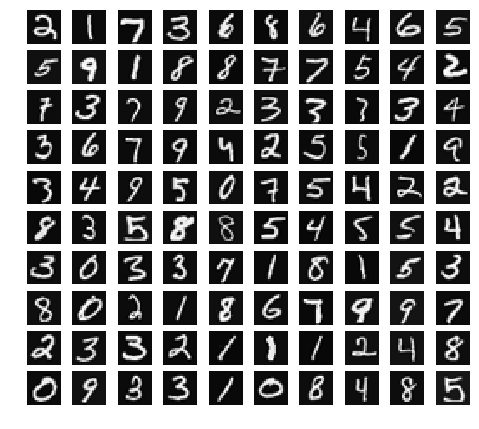

In [9]:
fig = displayData(sel)

### Logistic regression cost and gradient functions

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))   

In [11]:
def lrCostFunction(theta,X,y,lambda_reg=0):
    m = len(y)    
    theta = theta.reshape(-1,1)
    
    h = sigmoid(X.dot(theta))
    J = (1/m) * (-y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))) + (lambda_reg /(2 * m)) * np.sum(theta[1:,:]**2) 
    
    return np.asscalar(J)

In [12]:
def lrGradFunction(theta,X,y,lambda_reg=0):
    m = len(y)
    theta = theta.reshape(-1,1)
    
    h = sigmoid(X.dot(theta))
    grad = (1/m) * X.T.dot(h-y)
    grad[1:,:] = grad[1:,:] + (lambda_reg / m) * theta[1:,:]

    return grad.flatten()

### Part 2a: Vectorize Logistic Regression

In [13]:
theta_t = np.array([-2,-1,1,2])
X_t = np.c_[np.ones((5)),(np.arange(1,16)/10).reshape(5,3, order='F')]
y_t = np.array([1,0,1,0,1]).astype('int').reshape(5,-1)
lambda_t = 3

In [14]:
J_t = lrCostFunction(theta_t,X_t,y_t,lambda_t)
grad_t = lrGradFunction(theta_t,X_t,y_t,lambda_t)

In [15]:
print("Cost : {:2.6f} \n".format(J_t))
print('Expected cost : 2.534819\n')
print('Gradients : ')
print(' {}'.format(grad_t.reshape(4,-1)))
print('\nExpected gradients :\n  0.146561\n -0.548558\n 0.724722\n 1.398003\n')

Cost : 2.534819 

Expected cost : 2.534819

Gradients : 
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]

Expected gradients :
  0.146561
 -0.548558
 0.724722
 1.398003



### Part 2b: One-vs-All Training

In [16]:
def oneVsAll(X, y, num_labels, lambda_reg):
    m = X.shape[0]
    n = X.shape[1]
    
    all_theta = np.zeros((num_labels, n+1))
    
    X = np.c_[np.ones(m),X]
    
    for c in range(1, num_labels + 1):
        print("Training class {}".format(c))        
        initial_theta = np.zeros(n + 1).flatten()
        find_optim_theta = minimize(fun=lrCostFunction, x0=initial_theta,
                                    method = None, jac=lrGradFunction, 
                                    args = (X,y==c),
                                    options={'maxiter':50})
        theta_opt = find_optim_theta.x
        all_theta[c-1,:]=theta_opt
        
    return all_theta        

In [17]:
lambda_reg = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_reg)

Training class 1
Training class 2
Training class 3
Training class 4
Training class 5
Training class 6
Training class 7
Training class 8
Training class 9
Training class 10


### Part 3: Predict for One-Vs-All

In [18]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    
    X = np.c_[np.ones(m),X]
    
    # Return (m x num_labels) matrix containing for each sample, the probability that it belongs to a given class
    prob_matrix = sigmoid(X.dot(all_theta.T))
    
    # Return m-vector, containing for each sample the class having the max probability
    pred =  prob_matrix.argmax(axis=1)+1 # array is indexed from 0 to nbclasses -1
    
    return pred    

In [19]:
pred = predictOneVsAll(all_theta,X)

In [20]:
print("Training set accuracy = {:2.2f} %".format(np.mean((pred.reshape(-1,1) == y).astype('int'))*100))

Training set accuracy = 93.32 %


### With sklearn

In [21]:
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

In [22]:
lr = LogisticRegression(max_iter=50,
                        intercept_scaling=0,
                        solver='newton-cg',
                        multi_class='ovr') # ovr = one-vs-rest aka one-vs-all

In [23]:
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
# Use accuracy_score method from sklean.metrics to compute accuracy
print("Training set accuracy (sklearn) = {:2.2f} %".format(accuracy_score(y,lr.predict(X))*100))

Training set accuracy (sklearn) = 94.46 %
